ECG Signal Processing and Segmentation 
Load Raw ECG Data:

Reads a CSV file (100.csv) containing raw ECG signal data (MLII and V5 leads).

Normalizes the ADC values to real voltages.

Filter the Signal:

Applies a bandpass filter (0.5–50 Hz) to remove baseline drift and noise from both ECG channels.

Load Annotations:

Reads heartbeat annotations from a text file (100annotations.txt).

Fixes any placeholder symbols like + or " by replacing them with the correct beat label from a backup column.

Segment ECG Around Beats:

For each labeled heartbeat, extracts a 1-second ECG window (360 samples before and after the beat).

Flattens the 2-channel data (MLII & V5) into a feature vector of 720 values.

Export Processed Data:

Saves the segmented ECG beats to ecg_segments.xlsx.

Saves the corresponding labels to ecg_labels.xlsx.

In [7]:
import numpy as np
import pandas as pd
from scipy.signal import firwin, filtfilt

# === Stage 1: Load and Preprocess ECG Signal ===
df = pd.read_csv(r'C:\Users\ENAS.DESKTOP-CSI0DAD\Desktop\ecg\me\dataset\100.csv')
orginal_data_ecg = df.to_numpy()

# Normalize ADC signals (assumes ch1 and ch2 in cols 1 and 2)
data_ecg_1 = (orginal_data_ecg[:, 1:3] - 1024) / 200
data_ecg_2 = np.column_stack((orginal_data_ecg[:, 0], data_ecg_1))

# Bandpass filter design (0.5–50 Hz)
fs = 360
low_freq = 0.5
high_freq = 50
nyquist_freq = fs / 2
order = 100
filter_coefficients = firwin(order + 1, [low_freq / nyquist_freq, high_freq / nyquist_freq], pass_zero='bandpass')

# Apply zero-phase filtering
filtered_ecg_1 = filtfilt(filter_coefficients, 1.0, data_ecg_2[:, 1])
filtered_ecg_2 = filtfilt(filter_coefficients, 1.0, data_ecg_2[:, 2])
new_data = np.column_stack((data_ecg_2[:, 0], filtered_ecg_1, filtered_ecg_2))

# === Stage 2: Load and Clean Annotation Data ===
data_info = pd.read_csv(r'C:\Users\ENAS.DESKTOP-CSI0DAD\Desktop\ecg\me\dataset\100annotations.txt', delimiter='\t', header=None)

# Split annotation columns
first_column_split = data_info.iloc[:, 0].astype(str).str.split(expand=True)
first_column_split = first_column_split.rename(columns={0: 'Time', 1: 'Sample_Type', 2: 'SubChanNum'})
first_column_split['FourthColumn'] = data_info.iloc[:, 1].astype(str)

# Count and replace problematic SubChanNum entries
mask = first_column_split['SubChanNum'].isin(['+', '"']) | first_column_split['SubChanNum'].isna()
num_replaced = mask.sum()

first_column_split.loc[mask, 'SubChanNum'] = first_column_split.loc[mask, 'FourthColumn']

# Convert sample index to int
first_column_split['Sample_Type'] = pd.to_numeric(first_column_split['Sample_Type'], errors='coerce')
data_info_cleaned = first_column_split.dropna(subset=['Sample_Type'])
data_info_cleaned['Sample_Type'] = data_info_cleaned['Sample_Type'].astype(int)

print(f"✅ Annotation cleanup complete: {num_replaced} placeholder labels were replaced.")

# === Stage 3: Segment ECG Signal ===
segments = []
labels = []

for _, row in data_info_cleaned.iterrows():
    sample = row['Sample_Type']
    label = row['SubChanNum']
    start_idx = sample - 180
    end_idx = sample + 180

    segment = new_data[(new_data[:, 0] >= start_idx) & (new_data[:, 0] < end_idx), 1:]
    if segment.shape[0] == 360:
        flat_segment = segment.T.flatten()  # shape: (720,)
        segments.append(flat_segment)
        labels.append(label)

print(f"✅ Segmentation complete: {len(segments)} valid ECG segments extracted.")

# === Stage 4: Save to Separate Excel Files ===
df_segments = pd.DataFrame(segments)
df_labels = pd.DataFrame(labels, columns=["Label"])

segments_path = r'C:\Users\ENAS.DESKTOP-CSI0DAD\Desktop\ecg\me\dataset\ecg_segments.xlsx'
labels_path = r'C:\Users\ENAS.DESKTOP-CSI0DAD\Desktop\ecg\me\dataset\ecg_labels.xlsx'

df_segments.to_excel(segments_path, index=False)
df_labels.to_excel(labels_path, index=False)

print(f"✅ Saved segments to: {segments_path}")
print(f"✅ Saved labels to:   {labels_path}")


C:\Users\ENAS.DESKTOP-CSI0DAD\AppData\Local\Temp\ipykernel_14708\3841481848.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_info_cleaned['Sample_Type'] = data_info_cleaned['Sample_Type'].astype(int)


✅ Annotation cleanup complete: 1 placeholder labels were replaced.
✅ Segmentation complete: 2271 valid ECG segments extracted.
✅ Saved segments to: C:\Users\ENAS.DESKTOP-CSI0DAD\Desktop\ecg\me\dataset\ecg_segments.xlsx
✅ Saved labels to:   C:\Users\ENAS.DESKTOP-CSI0DAD\Desktop\ecg\me\dataset\ecg_labels.xlsx


In [8]:
import numpy as np
import pandas as pd
from scipy.signal import firwin, filtfilt
import os

# === Settings ===
input_folder = r'C:\Users\ENAS.DESKTOP-CSI0DAD\Desktop\ecg\me\dataset'
output_folder = os.path.join(input_folder, 'ECG Signal Processing and Segmentation')
os.makedirs(output_folder, exist_ok=True)  # Create folder if it doesn't exist

record_ids = list(range(100, 235))  # Adjust based on available subjects
fs = 360
low_freq = 0.5
high_freq = 50
order = 100
nyquist_freq = fs / 2
filter_coefficients = firwin(order + 1, [low_freq / nyquist_freq, high_freq / nyquist_freq], pass_zero='bandpass')

# === Loop Through Each Subject ===
for record_id in record_ids:
    try:
        ecg_file = os.path.join(input_folder, f'{record_id}.csv')
        ann_file = os.path.join(input_folder, f'{record_id}annotations.txt')

        if not os.path.exists(ecg_file) or not os.path.exists(ann_file):
            print(f"⚠️ Skipping record {record_id}: files missing.")
            continue

        # Load ECG data
        df = pd.read_csv(ecg_file)
        orginal_data_ecg = df.to_numpy()
        data_ecg_1 = (orginal_data_ecg[:, 1:3] - 1024) / 200
        data_ecg_2 = np.column_stack((orginal_data_ecg[:, 0], data_ecg_1))

        # Apply filtering
        filtered_ecg_1 = filtfilt(filter_coefficients, 1.0, data_ecg_2[:, 1])
        filtered_ecg_2 = filtfilt(filter_coefficients, 1.0, data_ecg_2[:, 2])
        new_data = np.column_stack((data_ecg_2[:, 0], filtered_ecg_1, filtered_ecg_2))

        # Load and process annotation file
        data_info = pd.read_csv(ann_file, delimiter='\t', header=None)
        first_column_split = data_info.iloc[:, 0].astype(str).str.split(expand=True)
        first_column_split = first_column_split.rename(columns={0: 'Time', 1: 'Sample_Type', 2: 'SubChanNum'})
        first_column_split['FourthColumn'] = data_info.iloc[:, 1].astype(str)

        mask = first_column_split['SubChanNum'].isin(['+', '"']) | first_column_split['SubChanNum'].isna()
        first_column_split.loc[mask, 'SubChanNum'] = first_column_split.loc[mask, 'FourthColumn']

        first_column_split['Sample_Type'] = pd.to_numeric(first_column_split['Sample_Type'], errors='coerce')
        data_info_cleaned = first_column_split.dropna(subset=['Sample_Type']).copy()
        data_info_cleaned['Sample_Type'] = data_info_cleaned['Sample_Type'].astype(int)

        # Segment ECG
        segments = []
        labels = []

        for _, row in data_info_cleaned.iterrows():
            sample = row['Sample_Type']
            label = row['SubChanNum']
            start_idx = sample - 180
            end_idx = sample + 180
            segment = new_data[(new_data[:, 0] >= start_idx) & (new_data[:, 0] < end_idx), 1:]
            if segment.shape[0] == 360:
                flat_segment = segment.T.flatten()
                segments.append(flat_segment)
                labels.append(label)

        # Save to new folder with original ID names
        df_segments = pd.DataFrame(segments)
        df_labels = pd.DataFrame(labels, columns=["Label"])

        segments_path = os.path.join(output_folder, f'{record_id}_segments.xlsx')
        labels_path = os.path.join(output_folder, f'{record_id}_labels.xlsx')

        df_segments.to_excel(segments_path, index=False)
        df_labels.to_excel(labels_path, index=False)

        print(f"✅ Saved: {record_id}_segments.xlsx and {record_id}_labels.xlsx")

    except Exception as e:
        print(f"❌ Error processing record {record_id}: {e}")


✅ Saved: 100_segments.xlsx and 100_labels.xlsx
✅ Saved: 101_segments.xlsx and 101_labels.xlsx
✅ Saved: 102_segments.xlsx and 102_labels.xlsx
✅ Saved: 103_segments.xlsx and 103_labels.xlsx
✅ Saved: 104_segments.xlsx and 104_labels.xlsx
✅ Saved: 105_segments.xlsx and 105_labels.xlsx
✅ Saved: 106_segments.xlsx and 106_labels.xlsx
✅ Saved: 107_segments.xlsx and 107_labels.xlsx
✅ Saved: 108_segments.xlsx and 108_labels.xlsx
✅ Saved: 109_segments.xlsx and 109_labels.xlsx
⚠️ Skipping record 110: files missing.
✅ Saved: 111_segments.xlsx and 111_labels.xlsx
✅ Saved: 112_segments.xlsx and 112_labels.xlsx
✅ Saved: 113_segments.xlsx and 113_labels.xlsx
✅ Saved: 114_segments.xlsx and 114_labels.xlsx
✅ Saved: 115_segments.xlsx and 115_labels.xlsx
✅ Saved: 116_segments.xlsx and 116_labels.xlsx
✅ Saved: 117_segments.xlsx and 117_labels.xlsx
✅ Saved: 118_segments.xlsx and 118_labels.xlsx
✅ Saved: 119_segments.xlsx and 119_labels.xlsx
⚠️ Skipping record 120: files missing.
✅ Saved: 121_segments.xlsx an

 Plot ECG Segments with Labels

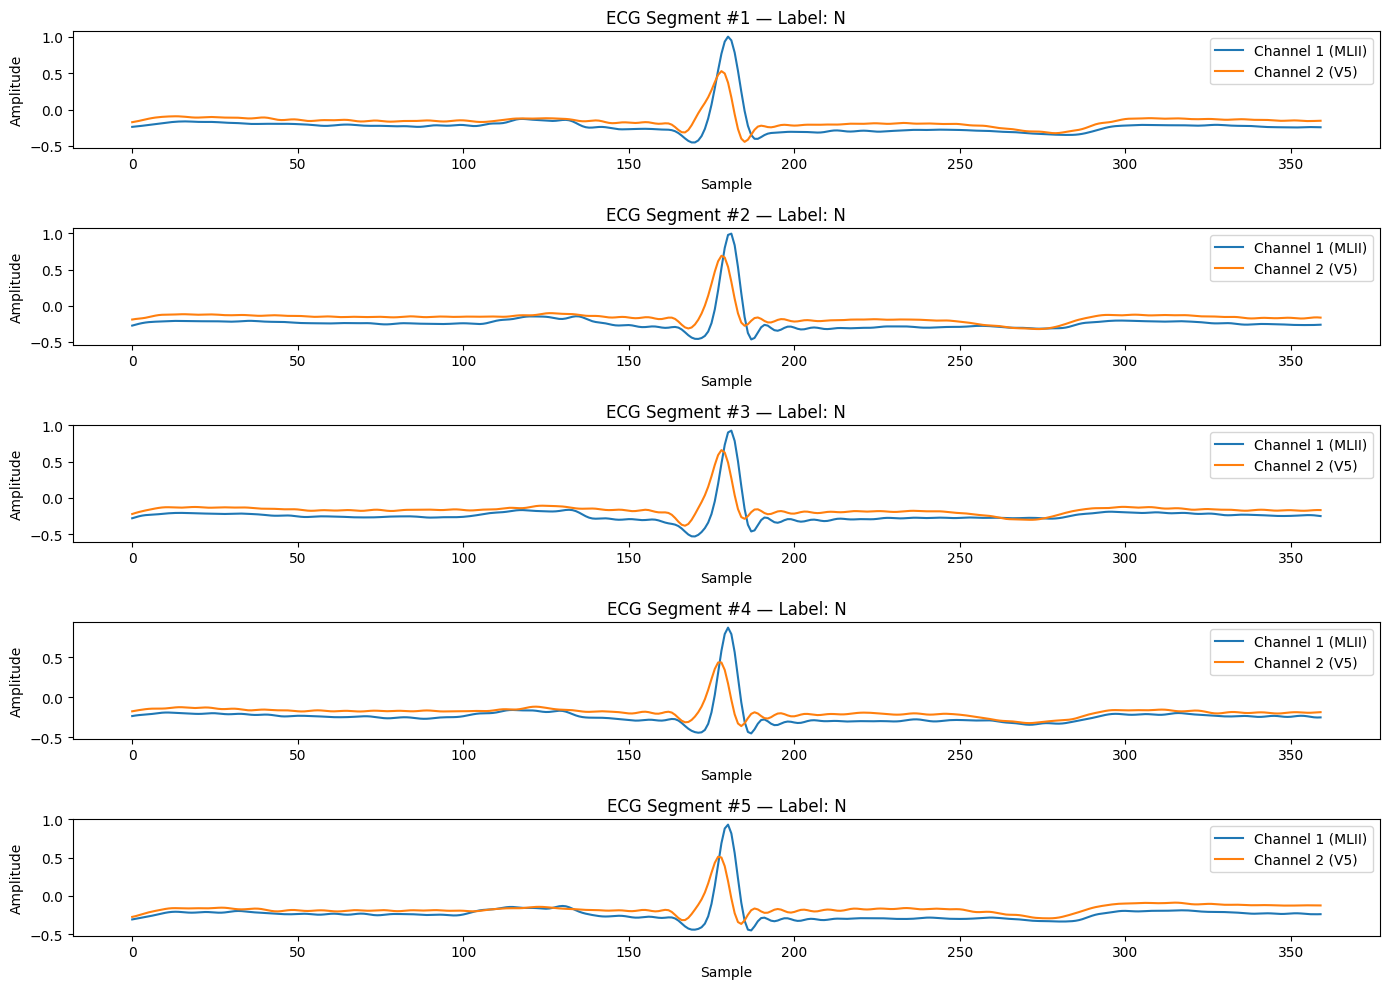

In [6]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# === Load Excel Files ===
segments_path = r'C:\Users\ENAS.DESKTOP-CSI0DAD\Desktop\ecg\me\dataset\ecg_segments.xlsx'
labels_path = r'C:\Users\ENAS.DESKTOP-CSI0DAD\Desktop\ecg\me\dataset\ecg_labels.xlsx'

df_segments = pd.read_excel(segments_path)
df_labels = pd.read_excel(labels_path)

# === Plot First 5 Segments ===
num_examples = 5
plt.figure(figsize=(14, 10))

for i in range(num_examples):
    segment = df_segments.iloc[i].values.reshape(2, 360)  # reshape to (2 channels x 360 samples)
    label = df_labels.iloc[i, 0]

    plt.subplot(num_examples, 1, i + 1)
    plt.plot(segment[0], label='Channel 1 (MLII)')
    plt.plot(segment[1], label='Channel 2 (V5)')
    plt.title(f'ECG Segment #{i+1} — Label: {label}')
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')
    plt.legend(loc='upper right')

plt.tight_layout()
plt.show()


# Features Extracted from Each Channel (MLII or V5)
**1. Time-Based Features (describe the shape of the signal)**
Feature	What it means (simple)
Mean	The average height of the signal
Standard Deviation	How much the signal values spread around the average
Minimum	The lowest point in the signal
Maximum	The highest point in the signal
Median	The middle value of the signal (not affected by outliers)
Skewness	Whether the signal leans more to one side (left/right)
Kurtosis	How sharp or flat the signal peaks are
Zero Crossings	How many times the signal crosses the zero line (wigglyness)
RMS (Root Mean Square)	A measure of signal energy
IEMG (Integrated EMG)	Total size/area of the signal
Waveform Length	How long or busy the signal shape is

**2. Hjorth Parameters (special shape info)**
These describe how active or complex the signal is.

Feature	What it means
Activity	How much the signal is changing overall
Mobility	How fast the signal is changing (like slope)
Complexity	How unpredictable or detailed the signal shape is

**3. Frequency-Based Feature**
Feature	What it means
Band Energy (0–10 Hz)	How much energy the signal has in the 0–10 Hz range (this is where most ECG info lives)

**We get:**
15 features per channel

2 channels per beat → 30 features total

In [10]:
import numpy as np
import pandas as pd
from scipy.stats import skew, kurtosis
from scipy.signal import welch
import os

# === Feature Extraction Functions ===
def hjorth_parameters(sig):
    first_deriv = np.diff(sig)
    second_deriv = np.diff(first_deriv)
    var_zero = np.var(sig)
    var_d1 = np.var(first_deriv)
    var_d2 = np.var(second_deriv)
    activity = var_zero
    mobility = np.sqrt(var_d1 / var_zero) if var_zero != 0 else 0
    complexity = np.sqrt(var_d2 / var_d1) / mobility if var_d1 != 0 and mobility != 0 else 0
    return activity, mobility, complexity

def band_energy(signal, fs=360, band=(0, 10)):
    freqs, psd = welch(signal, fs=fs)
    band_mask = (freqs >= band[0]) & (freqs <= band[1])
    return np.trapz(psd[band_mask], freqs[band_mask])

def extract_ecg_features(segment_2x360):
    features = []
    for ch in segment_2x360:
        features += [
            np.mean(ch), np.std(ch), np.min(ch), np.max(ch), np.median(ch),
            skew(ch), kurtosis(ch),
            np.sum(np.abs(np.diff(np.sign(ch)))) / 2,       # Zero crossing
            np.sqrt(np.mean(ch**2)),                        # RMS
            np.sum(np.abs(ch)),                             # IEMG
            np.sum(np.abs(np.diff(ch)))                     # Waveform length
        ]
        h1, h2, h3 = hjorth_parameters(ch)
        features += [h1, h2, h3]
        features += [band_energy(ch)]
    return features

# === Paths ===
input_folder = r'C:\Users\ENAS.DESKTOP-CSI0DAD\Desktop\ecg\me\dataset\ECG Signal Processing and Segmentation'
output_folder = os.path.join(input_folder, 'features')
os.makedirs(output_folder, exist_ok=True)

# === Process All Segment Files ===
for file in os.listdir(input_folder):
    if file.endswith('_segments.xlsx'):
        record_id = file.split('_')[0]
        segment_path = os.path.join(input_folder, file)
        try:
            df_segments = pd.read_excel(segment_path)
            all_features = []

            for _, row in df_segments.iterrows():
                segment_flat = row.to_numpy()
                segment_2x360 = segment_flat.reshape(2, 360)
                features = extract_ecg_features(segment_2x360)
                all_features.append(features)

            # Save extracted features
            df_features = pd.DataFrame(all_features)
            df_features.to_excel(os.path.join(output_folder, f'{record_id}_features.xlsx'), index=False)
            print(f"✅ Features saved for: {record_id}")

        except Exception as e:
            print(f"❌ Error processing {file}: {e}")


C:\Users\ENAS.DESKTOP-CSI0DAD\AppData\Local\Temp\ipykernel_14708\869928792.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(psd[band_mask], freqs[band_mask])


✅ Features saved for: 100


C:\Users\ENAS.DESKTOP-CSI0DAD\AppData\Local\Temp\ipykernel_14708\869928792.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(psd[band_mask], freqs[band_mask])


✅ Features saved for: 101


C:\Users\ENAS.DESKTOP-CSI0DAD\AppData\Local\Temp\ipykernel_14708\869928792.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(psd[band_mask], freqs[band_mask])


✅ Features saved for: 102


C:\Users\ENAS.DESKTOP-CSI0DAD\AppData\Local\Temp\ipykernel_14708\869928792.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(psd[band_mask], freqs[band_mask])


✅ Features saved for: 103


C:\Users\ENAS.DESKTOP-CSI0DAD\AppData\Local\Temp\ipykernel_14708\869928792.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(psd[band_mask], freqs[band_mask])


✅ Features saved for: 104


C:\Users\ENAS.DESKTOP-CSI0DAD\AppData\Local\Temp\ipykernel_14708\869928792.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(psd[band_mask], freqs[band_mask])


✅ Features saved for: 105


C:\Users\ENAS.DESKTOP-CSI0DAD\AppData\Local\Temp\ipykernel_14708\869928792.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(psd[band_mask], freqs[band_mask])


✅ Features saved for: 106


C:\Users\ENAS.DESKTOP-CSI0DAD\AppData\Local\Temp\ipykernel_14708\869928792.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(psd[band_mask], freqs[band_mask])


✅ Features saved for: 107


C:\Users\ENAS.DESKTOP-CSI0DAD\AppData\Local\Temp\ipykernel_14708\869928792.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(psd[band_mask], freqs[band_mask])


✅ Features saved for: 108


C:\Users\ENAS.DESKTOP-CSI0DAD\AppData\Local\Temp\ipykernel_14708\869928792.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(psd[band_mask], freqs[band_mask])


✅ Features saved for: 109


C:\Users\ENAS.DESKTOP-CSI0DAD\AppData\Local\Temp\ipykernel_14708\869928792.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(psd[band_mask], freqs[band_mask])


✅ Features saved for: 111


C:\Users\ENAS.DESKTOP-CSI0DAD\AppData\Local\Temp\ipykernel_14708\869928792.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(psd[band_mask], freqs[band_mask])


✅ Features saved for: 112


C:\Users\ENAS.DESKTOP-CSI0DAD\AppData\Local\Temp\ipykernel_14708\869928792.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(psd[band_mask], freqs[band_mask])


✅ Features saved for: 113


C:\Users\ENAS.DESKTOP-CSI0DAD\AppData\Local\Temp\ipykernel_14708\869928792.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(psd[band_mask], freqs[band_mask])


✅ Features saved for: 114


C:\Users\ENAS.DESKTOP-CSI0DAD\AppData\Local\Temp\ipykernel_14708\869928792.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(psd[band_mask], freqs[band_mask])


✅ Features saved for: 115


C:\Users\ENAS.DESKTOP-CSI0DAD\AppData\Local\Temp\ipykernel_14708\869928792.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(psd[band_mask], freqs[band_mask])


✅ Features saved for: 116


C:\Users\ENAS.DESKTOP-CSI0DAD\AppData\Local\Temp\ipykernel_14708\869928792.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(psd[band_mask], freqs[band_mask])


✅ Features saved for: 117


C:\Users\ENAS.DESKTOP-CSI0DAD\AppData\Local\Temp\ipykernel_14708\869928792.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(psd[band_mask], freqs[band_mask])


✅ Features saved for: 118


C:\Users\ENAS.DESKTOP-CSI0DAD\AppData\Local\Temp\ipykernel_14708\869928792.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(psd[band_mask], freqs[band_mask])


✅ Features saved for: 119


C:\Users\ENAS.DESKTOP-CSI0DAD\AppData\Local\Temp\ipykernel_14708\869928792.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(psd[band_mask], freqs[band_mask])


✅ Features saved for: 121


C:\Users\ENAS.DESKTOP-CSI0DAD\AppData\Local\Temp\ipykernel_14708\869928792.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(psd[band_mask], freqs[band_mask])


✅ Features saved for: 122


C:\Users\ENAS.DESKTOP-CSI0DAD\AppData\Local\Temp\ipykernel_14708\869928792.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(psd[band_mask], freqs[band_mask])


✅ Features saved for: 123


C:\Users\ENAS.DESKTOP-CSI0DAD\AppData\Local\Temp\ipykernel_14708\869928792.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(psd[band_mask], freqs[band_mask])


✅ Features saved for: 124


C:\Users\ENAS.DESKTOP-CSI0DAD\AppData\Local\Temp\ipykernel_14708\869928792.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(psd[band_mask], freqs[band_mask])


✅ Features saved for: 200


C:\Users\ENAS.DESKTOP-CSI0DAD\AppData\Local\Temp\ipykernel_14708\869928792.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(psd[band_mask], freqs[band_mask])


✅ Features saved for: 201


C:\Users\ENAS.DESKTOP-CSI0DAD\AppData\Local\Temp\ipykernel_14708\869928792.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(psd[band_mask], freqs[band_mask])


✅ Features saved for: 202


C:\Users\ENAS.DESKTOP-CSI0DAD\AppData\Local\Temp\ipykernel_14708\869928792.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(psd[band_mask], freqs[band_mask])


✅ Features saved for: 203


C:\Users\ENAS.DESKTOP-CSI0DAD\AppData\Local\Temp\ipykernel_14708\869928792.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(psd[band_mask], freqs[band_mask])


✅ Features saved for: 205


C:\Users\ENAS.DESKTOP-CSI0DAD\AppData\Local\Temp\ipykernel_14708\869928792.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(psd[band_mask], freqs[band_mask])


✅ Features saved for: 207


C:\Users\ENAS.DESKTOP-CSI0DAD\AppData\Local\Temp\ipykernel_14708\869928792.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(psd[band_mask], freqs[band_mask])


✅ Features saved for: 208


C:\Users\ENAS.DESKTOP-CSI0DAD\AppData\Local\Temp\ipykernel_14708\869928792.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(psd[band_mask], freqs[band_mask])


✅ Features saved for: 209


C:\Users\ENAS.DESKTOP-CSI0DAD\AppData\Local\Temp\ipykernel_14708\869928792.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(psd[band_mask], freqs[band_mask])


✅ Features saved for: 210


C:\Users\ENAS.DESKTOP-CSI0DAD\AppData\Local\Temp\ipykernel_14708\869928792.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(psd[band_mask], freqs[band_mask])


✅ Features saved for: 212


C:\Users\ENAS.DESKTOP-CSI0DAD\AppData\Local\Temp\ipykernel_14708\869928792.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(psd[band_mask], freqs[band_mask])


✅ Features saved for: 213


C:\Users\ENAS.DESKTOP-CSI0DAD\AppData\Local\Temp\ipykernel_14708\869928792.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(psd[band_mask], freqs[band_mask])


✅ Features saved for: 214


C:\Users\ENAS.DESKTOP-CSI0DAD\AppData\Local\Temp\ipykernel_14708\869928792.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(psd[band_mask], freqs[band_mask])


✅ Features saved for: 215


C:\Users\ENAS.DESKTOP-CSI0DAD\AppData\Local\Temp\ipykernel_14708\869928792.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(psd[band_mask], freqs[band_mask])


✅ Features saved for: 217


C:\Users\ENAS.DESKTOP-CSI0DAD\AppData\Local\Temp\ipykernel_14708\869928792.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(psd[band_mask], freqs[band_mask])


✅ Features saved for: 219


C:\Users\ENAS.DESKTOP-CSI0DAD\AppData\Local\Temp\ipykernel_14708\869928792.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(psd[band_mask], freqs[band_mask])


✅ Features saved for: 220


C:\Users\ENAS.DESKTOP-CSI0DAD\AppData\Local\Temp\ipykernel_14708\869928792.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(psd[band_mask], freqs[band_mask])


✅ Features saved for: 221


C:\Users\ENAS.DESKTOP-CSI0DAD\AppData\Local\Temp\ipykernel_14708\869928792.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(psd[band_mask], freqs[band_mask])


✅ Features saved for: 222


C:\Users\ENAS.DESKTOP-CSI0DAD\AppData\Local\Temp\ipykernel_14708\869928792.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(psd[band_mask], freqs[band_mask])


✅ Features saved for: 223


C:\Users\ENAS.DESKTOP-CSI0DAD\AppData\Local\Temp\ipykernel_14708\869928792.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(psd[band_mask], freqs[band_mask])


✅ Features saved for: 228


C:\Users\ENAS.DESKTOP-CSI0DAD\AppData\Local\Temp\ipykernel_14708\869928792.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(psd[band_mask], freqs[band_mask])


✅ Features saved for: 230


C:\Users\ENAS.DESKTOP-CSI0DAD\AppData\Local\Temp\ipykernel_14708\869928792.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(psd[band_mask], freqs[band_mask])


✅ Features saved for: 231


C:\Users\ENAS.DESKTOP-CSI0DAD\AppData\Local\Temp\ipykernel_14708\869928792.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(psd[band_mask], freqs[band_mask])


✅ Features saved for: 232


C:\Users\ENAS.DESKTOP-CSI0DAD\AppData\Local\Temp\ipykernel_14708\869928792.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(psd[band_mask], freqs[band_mask])


✅ Features saved for: 233


C:\Users\ENAS.DESKTOP-CSI0DAD\AppData\Local\Temp\ipykernel_14708\869928792.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(psd[band_mask], freqs[band_mask])


✅ Features saved for: 234


# ===============================================================
 Loops through subject IDs from 100 to 234.

 Loads corresponding feature and label Excel files.

 Merges them horizontally (side-by-side).

 Saves the result as a new Excel file (e.g., subject114.xlsx).

# ===============================================================


In [3]:

import os
import pandas as pd

# === Folder paths ===
features_folder = r'C:\Users\ENAS.DESKTOP-CSI0DAD\Desktop\ecg\me\dataset\ECG Signal Processing and Segmentation\features'
labels_folder = r'C:\Users\ENAS.DESKTOP-CSI0DAD\Desktop\ecg\me\dataset\ECG Signal Processing and Segmentation\labels'
output_folder = r'C:\Users\ENAS.DESKTOP-CSI0DAD\Desktop\ecg\me\dataset\ECG Signal Processing and Segmentation\concatenated_data_excel'
os.makedirs(output_folder, exist_ok=True)

# === Loop through all subject files ===
for i in range(100, 235):
    feature_file = os.path.join(features_folder, f'{i}_features.xlsx')
    label_file = os.path.join(labels_folder, f'{i}_labels.xlsx')
    output_file = os.path.join(output_folder, f'subject{i}.xlsx')

    if os.path.exists(feature_file) and os.path.exists(label_file):
        try:
            # Load Excel files
            features_df = pd.read_excel(feature_file)
            labels_df = pd.read_excel(label_file)

            # Combine features and labels column-wise
            combined = pd.concat([features_df, labels_df], axis=1)

            # Save combined data as new Excel file
            combined.to_excel(output_file, index=False)
            print(f"✅ Saved: subject{i}.xlsx")

        except Exception as e:
            print(f"❌ Error processing subject{i}: {e}")
    else:
        print(f"⚠️ Missing files for subject{i}")

print("✅ All Excel files processed!")

✅ Saved: subject100.xlsx
✅ Saved: subject101.xlsx
✅ Saved: subject102.xlsx
✅ Saved: subject103.xlsx
✅ Saved: subject104.xlsx
✅ Saved: subject105.xlsx
✅ Saved: subject106.xlsx
✅ Saved: subject107.xlsx
✅ Saved: subject108.xlsx
✅ Saved: subject109.xlsx
⚠️ Missing files for subject110
✅ Saved: subject111.xlsx
✅ Saved: subject112.xlsx
✅ Saved: subject113.xlsx
✅ Saved: subject114.xlsx
✅ Saved: subject115.xlsx
✅ Saved: subject116.xlsx
✅ Saved: subject117.xlsx
✅ Saved: subject118.xlsx
✅ Saved: subject119.xlsx
⚠️ Missing files for subject120
✅ Saved: subject121.xlsx
✅ Saved: subject122.xlsx
✅ Saved: subject123.xlsx
✅ Saved: subject124.xlsx
⚠️ Missing files for subject125
⚠️ Missing files for subject126
⚠️ Missing files for subject127
⚠️ Missing files for subject128
⚠️ Missing files for subject129
⚠️ Missing files for subject130
⚠️ Missing files for subject131
⚠️ Missing files for subject132
⚠️ Missing files for subject133
⚠️ Missing files for subject134
⚠️ Missing files for subject135
⚠️ Missin

# ===============================================================
Title: ECG Label Grouping - Modify Excel Data Labels
Description: This script reads Excel files containing ECG features 
              and labels, replaces original label values based on 
              grouping rules (N, S, V, Q), and saves the modified data.
 Input:  subjectXXX.xlsx files with labels in the last column
 Output: Modified subjectXXX.xlsx files with updated labels
 
# ===============================================================

In [5]:

import os
import pandas as pd

# === Define directories ===
input_dir = r'C:\Users\ENAS.DESKTOP-CSI0DAD\Desktop\ecg\me\dataset\ECG Signal Processing and Segmentation\concatenated_data_excel'
output_dir = r'C:\Users\ENAS.DESKTOP-CSI0DAD\Desktop\ecg\me\dataset\ECG Signal Processing and Segmentation\modified_data_excel'
os.makedirs(output_dir, exist_ok=True)

# === Define label grouping rules ===
replace_rules = {
    'N': ['N', 'L', 'R', 'e', 'j'],
    'S': ['A', 'a', 'J', 'S'],
    'V': ['V', 'E'],
    'Q': ['/', 'f', 'Q']
}

# === Function to replace labels ===
def replace_labels(labels, replace_rules):
    labels = labels.astype(str)
    for new_label, old_labels in replace_rules.items():
        labels = labels.replace(old_labels, new_label)
    return labels

# === Loop through all subject Excel files ===
for file_name in os.listdir(input_dir):
    if file_name.endswith('.xlsx') and file_name.startswith('subject'):
        input_file = os.path.join(input_dir, file_name)

        try:
            df = pd.read_excel(input_file)

            print(f"\nProcessing {file_name} - Shape: {df.shape}")

            # Replace labels in the last column
            df.iloc[:, -1] = replace_labels(df.iloc[:, -1], replace_rules)

            # Save the modified Excel file
            output_file = os.path.join(output_dir, file_name)
            df.to_excel(output_file, index=False)
            print(f"✅ Saved modified file: {file_name}")

        except Exception as e:
            print(f"❌ Error processing {file_name}: {e}")

print("\n✅ All Excel files processed successfully.")


Processing subject100.xlsx - Shape: (2271, 31)
✅ Saved modified file: subject100.xlsx

Processing subject101.xlsx - Shape: (1872, 31)
✅ Saved modified file: subject101.xlsx

Processing subject102.xlsx - Shape: (2189, 31)
✅ Saved modified file: subject102.xlsx

Processing subject103.xlsx - Shape: (2089, 31)
✅ Saved modified file: subject103.xlsx

Processing subject104.xlsx - Shape: (2308, 31)
✅ Saved modified file: subject104.xlsx

Processing subject105.xlsx - Shape: (2690, 31)
✅ Saved modified file: subject105.xlsx

Processing subject106.xlsx - Shape: (2097, 31)
✅ Saved modified file: subject106.xlsx

Processing subject107.xlsx - Shape: (2138, 31)
✅ Saved modified file: subject107.xlsx

Processing subject108.xlsx - Shape: (1822, 31)
✅ Saved modified file: subject108.xlsx

Processing subject109.xlsx - Shape: (2532, 31)
✅ Saved modified file: subject109.xlsx

Processing subject111.xlsx - Shape: (2132, 31)
✅ Saved modified file: subject111.xlsx

Processing subject112.xlsx - Shape: (2547,

# Define the valid labels to keep
**valid_labels = {'N', 'S', 'V', 'F', 'Q'}**

In [7]:

import os
import pandas as pd
import numpy as np

# === Define folder paths ===
input_dir = r'C:\Users\ENAS.DESKTOP-CSI0DAD\Desktop\ecg\me\dataset\ECG Signal Processing and Segmentation\modified_data_excel'
output_dir = r'C:\Users\ENAS.DESKTOP-CSI0DAD\Desktop\ecg\me\dataset\ECG Signal Processing and Segmentation\filtered_data_valid_labels={N,S,V,F,Q}'
os.makedirs(output_dir, exist_ok=True)

# === Valid labels to keep ===
valid_labels = {'N', 'S', 'V', 'F', 'Q'}

# === Process all subject Excel files ===
for file_name in os.listdir(input_dir):
    if file_name.endswith('.xlsx') and file_name.startswith('subject'):
        input_file = os.path.join(input_dir, file_name)
        
        try:
            # Load Excel file
            df = pd.read_excel(input_file)

            # Extract labels (assumed last column)
            labels = df.iloc[:, -1].astype(str)

            # Filter rows where label is valid
            valid_rows = labels.isin(valid_labels)
            filtered_df = df[valid_rows]

            # Save to new Excel file
            output_file = os.path.join(output_dir, file_name)
            filtered_df.to_excel(output_file, index=False)
            print(f"✅ Filtered and saved: {file_name}")

        except Exception as e:
            print(f"❌ Error processing {file_name}: {e}")

print("\n✅ All Excel files filtered successfully.")

✅ Filtered and saved: subject100.xlsx
✅ Filtered and saved: subject101.xlsx
✅ Filtered and saved: subject102.xlsx
✅ Filtered and saved: subject103.xlsx
✅ Filtered and saved: subject104.xlsx
✅ Filtered and saved: subject105.xlsx
✅ Filtered and saved: subject106.xlsx
✅ Filtered and saved: subject107.xlsx
✅ Filtered and saved: subject108.xlsx
✅ Filtered and saved: subject109.xlsx
✅ Filtered and saved: subject111.xlsx
✅ Filtered and saved: subject112.xlsx
✅ Filtered and saved: subject113.xlsx
✅ Filtered and saved: subject114.xlsx
✅ Filtered and saved: subject115.xlsx
✅ Filtered and saved: subject116.xlsx
✅ Filtered and saved: subject117.xlsx
✅ Filtered and saved: subject118.xlsx
✅ Filtered and saved: subject119.xlsx
✅ Filtered and saved: subject121.xlsx
✅ Filtered and saved: subject122.xlsx
✅ Filtered and saved: subject123.xlsx
✅ Filtered and saved: subject124.xlsx
✅ Filtered and saved: subject200.xlsx
✅ Filtered and saved: subject201.xlsx
✅ Filtered and saved: subject202.xlsx
✅ Filtered a

Read every subject*.xlsx file.

Extract all rows (features + labels).

Concatenate them into one big DataFrame.

Save the result as a new Excel file:
📄 combined_ecg_data.xlsx



In [1]:
import os
import pandas as pd

# === Define input folder and output file ===
input_dir = r'C:\Users\ENAS.DESKTOP-CSI0DAD\Desktop\ecg\me\dataset\ECG Signal Processing and Segmentation\filtered_data_valid_labels={N,S,V,F,Q}'
output_file = r'C:\Users\ENAS.DESKTOP-CSI0DAD\Desktop\ecg\me\dataset\ECG Signal Processing and Segmentation\combined_ecg_data.xlsx'

# === Store all data here ===
all_data = []

# === Loop through Excel files and combine ===
for file_name in os.listdir(input_dir):
    if file_name.endswith('.xlsx') and file_name.startswith('subject'):
        file_path = os.path.join(input_dir, file_name)
        try:
            df = pd.read_excel(file_path)
            all_data.append(df)
            print(f"✅ Loaded: {file_name}")
        except Exception as e:
            print(f"❌ Failed to load {file_name}: {e}")

# === Combine all dataframes ===
if all_data:
    combined_df = pd.concat(all_data, ignore_index=True)
    combined_df.to_excel(output_file, index=False)
    print(f"\n✅ Combined data saved to: {output_file}")
else:
    print("❌ No data files were loaded. Please check the folder path and files.")


✅ Loaded: subject100.xlsx
✅ Loaded: subject101.xlsx
✅ Loaded: subject102.xlsx
✅ Loaded: subject103.xlsx
✅ Loaded: subject104.xlsx
✅ Loaded: subject105.xlsx
✅ Loaded: subject106.xlsx
✅ Loaded: subject107.xlsx
✅ Loaded: subject108.xlsx
✅ Loaded: subject109.xlsx
✅ Loaded: subject111.xlsx
✅ Loaded: subject112.xlsx
✅ Loaded: subject113.xlsx
✅ Loaded: subject114.xlsx
✅ Loaded: subject115.xlsx
✅ Loaded: subject116.xlsx
✅ Loaded: subject117.xlsx
✅ Loaded: subject118.xlsx
✅ Loaded: subject119.xlsx
✅ Loaded: subject121.xlsx
✅ Loaded: subject122.xlsx
✅ Loaded: subject123.xlsx
✅ Loaded: subject124.xlsx
✅ Loaded: subject200.xlsx
✅ Loaded: subject201.xlsx
✅ Loaded: subject202.xlsx
✅ Loaded: subject203.xlsx
✅ Loaded: subject205.xlsx
✅ Loaded: subject207.xlsx
✅ Loaded: subject208.xlsx
✅ Loaded: subject209.xlsx
✅ Loaded: subject210.xlsx
✅ Loaded: subject212.xlsx
✅ Loaded: subject213.xlsx
✅ Loaded: subject214.xlsx
✅ Loaded: subject215.xlsx
✅ Loaded: subject217.xlsx
✅ Loaded: subject219.xlsx
✅ Loaded: su

Count Labels from Combined File

In [2]:
import pandas as pd

# === Load the combined Excel file ===
combined_file = r'C:\Users\ENAS.DESKTOP-CSI0DAD\Desktop\ecg\me\dataset\ECG Signal Processing and Segmentation\combined_ecg_data.xlsx'
df = pd.read_excel(combined_file)

# === Get the last column (assumed to be labels) ===
label_column = df.columns[-1]
labels = df[label_column].astype(str)  # ensure labels are strings

# === Count each label ===
label_counts = labels.value_counts()

# === Print the result ===
print("\n Label Counts:")
print(label_counts)



📊 Label Counts:
Label
N    90582
Q     8038
V     7235
S     2781
F      802
Name: count, dtype: int64




RandomUnderSampler to downsample 'N' from ~90k to 30k ✅

SMOTE to oversample minority classes like 'F' ✅

TomekLinks to clean borderline/noisy examples ✅

In [6]:
import pandas as pd
import numpy as np
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from imblearn.over_sampling import SMOTE
from collections import Counter

# === Load the combined Excel file ===
data_path = r'C:\Users\ENAS.DESKTOP-CSI0DAD\Desktop\ecg\me\dataset\ECG Signal Processing and Segmentation\combined_ecg_data.xlsx'
df = pd.read_excel(data_path)

# === Extract features and labels
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].astype(str).values  # Ensure labels are strings

# === Check original distribution
print(f"Initial class distribution: {Counter(y)}")

# === Step 1: Undersample majority class 'N'
undersample = RandomUnderSampler(sampling_strategy={'N': 30000}, random_state=42)
X_under, y_under = undersample.fit_resample(X, y)
print(f"After undersampling: {Counter(y_under)}")

# === Step 2: SMOTE to oversample minority classes
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_under, y_under)
print(f"After SMOTE oversampling: {Counter(y_resampled)}")

# === Step 3: Clean overlapping classes using Tomek Links
tomek = TomekLinks()
X_cleaned, y_cleaned = tomek.fit_resample(X_resampled, y_resampled)
print(f"After TomekLinks cleaning: {Counter(y_cleaned)}")

# === Save only as Excel
final_df = pd.DataFrame(np.hstack((X_cleaned, y_cleaned.reshape(-1, 1))))
output_excel = r'C:\Users\ENAS.DESKTOP-CSI0DAD\Desktop\ecg\me\dataset\ECG Signal Processing and Segmentation\balanced_ecg_data.xlsx'
final_df.to_excel(output_excel, index=False)

# === Final Check
print("\n Balanced data saved to Excel.")


Initial class distribution: Counter({'N': 90582, 'Q': 8038, 'V': 7235, 'S': 2781, 'F': 802})
After undersampling: Counter({'N': 30000, 'Q': 8038, 'V': 7235, 'S': 2781, 'F': 802})
After SMOTE oversampling: Counter({'F': 30000, 'N': 30000, 'Q': 30000, 'S': 30000, 'V': 30000})
After TomekLinks cleaning: Counter({'F': 30000, 'Q': 29967, 'V': 29957, 'S': 29887, 'N': 29833})

 Balanced data saved to Excel.


Count Labels after balancing

In [7]:
import pandas as pd

# === Load the combined Excel file ===
combined_file = r'C:\Users\ENAS.DESKTOP-CSI0DAD\Desktop\ecg\me\dataset\ECG Signal Processing and Segmentation\balanced_ecg_data.xlsx'
df = pd.read_excel(combined_file)

# === Get the last column (assumed to be labels) ===
label_column = df.columns[-1]
labels = df[label_column].astype(str)  # ensure labels are strings

# === Count each label ===
label_counts = labels.value_counts()

# === Print the result ===
print("\n Label Counts:")
print(label_counts)



 Label Counts:
30
F    30000
Q    29967
V    29957
S    29887
N    29833
Name: count, dtype: int64


Undersamples 'N' down to 8,000 samples.

Oversamples minority classes (Q, V, S, F) to 8,000 samples each using SMOTE.

Applies Tomek Links cleaning to remove noisy borderline samples (optional but included).




In [10]:
import pandas as pd
import numpy as np
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from collections import Counter

# Load your data
data_path = r'C:\Users\ENAS.DESKTOP-CSI0DAD\Desktop\ecg\me\dataset\ECG Signal Processing and Segmentation\combined_ecg_data.xlsx'
df = pd.read_excel(data_path)

X = df.iloc[:, :-1].values
y = df.iloc[:, -1].astype(str).values

print(f"Original class distribution:\n{Counter(y)}")

# Set target size to 8,000
target_size = 8000

# Step 1: Undersample majority class 'N' to target_size
undersample = RandomUnderSampler(sampling_strategy={'N': target_size}, random_state=42)
X_under, y_under = undersample.fit_resample(X, y)
print(f"\nAfter undersampling 'N':\n{Counter(y_under)}")

# Step 2: Oversample minority classes (Q, V, S, F) up to target_size
sampling_strategy = {
    label: target_size
    for label in np.unique(y_under)
    if np.sum(y_under == label) < target_size and label != 'N'
}

smote = SMOTE(sampling_strategy=sampling_strategy, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_under, y_under)
print(f"\nAfter SMOTE oversampling:\n{Counter(y_resampled)}")

# Step 3: Optional - Apply Tomek Links cleaning
tomek = TomekLinks()
X_cleaned, y_cleaned = tomek.fit_resample(X_resampled, y_resampled)
print(f"\nAfter Tomek Links cleaning:\n{Counter(y_cleaned)}")

# Step 4: Save the balanced data to Excel
final_df = pd.DataFrame(np.hstack((X_cleaned, y_cleaned.reshape(-1, 1))))
output_excel = r'C:\Users\ENAS.DESKTOP-CSI0DAD\Desktop\ecg\me\dataset\ECG Signal Processing and Segmentation\balanced_ecg_data_target8000_tomek.xlsx'
final_df.to_excel(output_excel, index=False)

print("\nFinal balanced dataset saved.")


Original class distribution:
Counter({'N': 90582, 'Q': 8038, 'V': 7235, 'S': 2781, 'F': 802})

After undersampling 'N':
Counter({'Q': 8038, 'N': 8000, 'V': 7235, 'S': 2781, 'F': 802})

After SMOTE oversampling:
Counter({'Q': 8038, 'F': 8000, 'N': 8000, 'S': 8000, 'V': 8000})

After Tomek Links cleaning:
Counter({'F': 8000, 'S': 7892, 'Q': 7887, 'V': 7786, 'N': 7697})

Final balanced dataset saved.


Count Labels after balancing

In [11]:
import pandas as pd

# === Load the combined Excel file ===
combined_file = r'C:\Users\ENAS.DESKTOP-CSI0DAD\Desktop\ecg\me\dataset\ECG Signal Processing and Segmentation\balanced_ecg_data_target8000_tomek.xlsx'
df = pd.read_excel(combined_file)

# === Get the last column (assumed to be labels) ===
label_column = df.columns[-1]
labels = df[label_column].astype(str)  # ensure labels are strings

# === Count each label ===
label_counts = labels.value_counts()

# === Print the result ===
print("\n Label Counts:")
print(label_counts)



 Label Counts:
30
F    8000
S    7892
Q    7887
V    7786
N    7697
Name: count, dtype: int64


Splits it into training/testing sets.

Trains and evaluates a Random Forest classifier.

In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from collections import Counter

# Load the balanced Excel file
data_path = r'C:\Users\ENAS.DESKTOP-CSI0DAD\Desktop\ecg\me\dataset\ECG Signal Processing and Segmentation\balanced_ecg_data_target8000_tomek.xlsx'
df = pd.read_excel(data_path)

# Extract features and labels
X_balanced = df.iloc[:, :-1].values
y_balanced = df.iloc[:, -1].astype(str).values  # Ensure labels are strings

# Show class distribution
print(f"Class distribution in balanced data: {Counter(y_balanced)}")

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_balanced, y_balanced, test_size=0.3, random_state=42
)

# Train the Random Forest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Predict on test data
y_pred = clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Output results
print(f"\nAccuracy: {accuracy}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)


Class distribution in balanced data: Counter({'F': 8000, 'S': 7892, 'Q': 7887, 'V': 7786, 'N': 7697})

Accuracy: 0.968248577977757
Confusion Matrix:
[[2413    9    1    0   22]
 [  10 2222    1   83   58]
 [   1    6 2292    4   14]
 [   4   83    0 2235   20]
 [  17   28    5    8 2243]]
Classification Report:
              precision    recall  f1-score   support

           F       0.99      0.99      0.99      2445
           N       0.95      0.94      0.94      2374
           Q       1.00      0.99      0.99      2317
           S       0.96      0.95      0.96      2342
           V       0.95      0.97      0.96      2301

    accuracy                           0.97     11779
   macro avg       0.97      0.97      0.97     11779
weighted avg       0.97      0.97      0.97     11779



Load the original imbalanced dataset from the .xlsx file.

Split into train and test (e.g., 70% train / 30% test).

Apply balancing (undersampling + SMOTE + optional Tomek) only on the training data.

Save balanced training data and raw imbalanced test data separately.



In [14]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from imblearn.over_sampling import SMOTE
from collections import Counter

# === 1. Load the original imbalanced data ===
data_path = r'C:\Users\ENAS.DESKTOP-CSI0DAD\Desktop\ecg\me\dataset\ECG Signal Processing and Segmentation\combined_ecg_data.xlsx'
df = pd.read_excel(data_path)

# === 2. Extract features and labels ===
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].astype(str).values  # Convert labels to strings

# === 3. Split the original data into train/test before balancing ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

print(f"\nOriginal Train Set Distribution:\n{Counter(y_train)}")
print(f"Original Test Set Distribution:\n{Counter(y_test)}")

# === 4. Balance the training set ONLY ===

# Step 1: Undersample majority class 'N' to target size
target_size = 8000
undersample = RandomUnderSampler(sampling_strategy={'N': target_size}, random_state=42)
X_train_under, y_train_under = undersample.fit_resample(X_train, y_train)
print(f"\nAfter undersampling 'N':\n{Counter(y_train_under)}")

# Step 2: SMOTE oversample minority classes to target size
sampling_strategy = {
    label: target_size
    for label in np.unique(y_train_under)
    if np.sum(y_train_under == label) < target_size and label != 'N'
}

smote = SMOTE(sampling_strategy=sampling_strategy, random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_under, y_train_under)
print(f"\nAfter SMOTE oversampling:\n{Counter(y_train_balanced)}")

# Step 3: (Optional) Clean with Tomek Links
tomek = TomekLinks()
X_train_cleaned, y_train_cleaned = tomek.fit_resample(X_train_balanced, y_train_balanced)
print(f"\nAfter Tomek Links cleaning:\n{Counter(y_train_cleaned)}")

# === 5. Save the balanced training and imbalanced test sets ===
# Save balanced training set
train_df = pd.DataFrame(np.hstack((X_train_cleaned, y_train_cleaned.reshape(-1, 1))))
train_output = r'C:\Users\ENAS.DESKTOP-CSI0DAD\Desktop\ecg\me\dataset\ECG Signal Processing and Segmentation\train_balanced_8000.xlsx'
train_df.to_excel(train_output, index=False)

# Save test set as-is (imbalanced)
test_df = pd.DataFrame(np.hstack((X_test, y_test.reshape(-1, 1))))
test_output = r'C:\Users\ENAS.DESKTOP-CSI0DAD\Desktop\ecg\me\dataset\ECG Signal Processing and Segmentation\test_imbalanced.xlsx'
test_df.to_excel(test_output, index=False)

print("\n✅ Balanced training set and imbalanced test set saved successfully.")



Original Train Set Distribution:
Counter({'N': 63407, 'Q': 5627, 'V': 5064, 'S': 1947, 'F': 561})
Original Test Set Distribution:
Counter({'N': 27175, 'Q': 2411, 'V': 2171, 'S': 834, 'F': 241})

After undersampling 'N':
Counter({'N': 8000, 'Q': 5627, 'V': 5064, 'S': 1947, 'F': 561})

After SMOTE oversampling:
Counter({'F': 8000, 'N': 8000, 'Q': 8000, 'S': 8000, 'V': 8000})

After Tomek Links cleaning:
Counter({'F': 8000, 'Q': 7924, 'S': 7920, 'V': 7905, 'N': 7816})

✅ Balanced training set and imbalanced test set saved successfully.


Count Labels 

In [16]:
import pandas as pd

# === Load the combined Excel file ===
combined_file = r'C:\Users\ENAS.DESKTOP-CSI0DAD\Desktop\ecg\me\dataset\ECG Signal Processing and Segmentation\test_imbalanced.xlsx'
df = pd.read_excel(combined_file)

# === Get the last column (assumed to be labels) ===
label_column = df.columns[-1]
labels = df[label_column].astype(str)  # ensure labels are strings

# === Count each label ===
label_counts = labels.value_counts()

# === Print the result ===
print("\n Label Counts:")
print(label_counts)



 Label Counts:
30
N    27175
Q     2411
V     2171
S      834
F      241
Name: count, dtype: int64


Loads the balanced training set

Loads the imbalanced test set

Trains the model only on the balanced data

Evaluates performance on real (imbalanced) test data

In [17]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from collections import Counter

# === 1. Load the balanced training set ===
train_path = r'C:\Users\ENAS.DESKTOP-CSI0DAD\Desktop\ecg\me\dataset\ECG Signal Processing and Segmentation\train_balanced_8000.xlsx'
train_df = pd.read_excel(train_path)
X_train = train_df.iloc[:, :-1].values
y_train = train_df.iloc[:, -1].astype(str).values

# === 2. Load the imbalanced test set ===
test_path = r'C:\Users\ENAS.DESKTOP-CSI0DAD\Desktop\ecg\me\dataset\ECG Signal Processing and Segmentation\test_imbalanced.xlsx'
test_df = pd.read_excel(test_path)
X_test = test_df.iloc[:, :-1].values
y_test = test_df.iloc[:, -1].astype(str).values

# === 3. Show class distributions ===
print(f"Train class distribution: {Counter(y_train)}")
print(f"Test class distribution: {Counter(y_test)}")

# === 4. Train the Random Forest classifier ===
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# === 5. Predict on the imbalanced test data ===
y_pred = clf.predict(X_test)

# === 6. Evaluate the model ===
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# === 7. Output the results ===
print(f"\nAccuracy: {accuracy:.4f}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)


Train class distribution: Counter({'F': 8000, 'Q': 7924, 'S': 7920, 'V': 7905, 'N': 7816})
Test class distribution: Counter({'N': 27175, 'Q': 2411, 'V': 2171, 'S': 834, 'F': 241})

Accuracy: 0.9537
Confusion Matrix:
[[  208    11     0     0    22]
 [  110 25875    40   500   650]
 [    2     3  2385     3    18]
 [    1    92     2   728    11]
 [   18    33     0     4  2116]]
Classification Report:
              precision    recall  f1-score   support

           F       0.61      0.86      0.72       241
           N       0.99      0.95      0.97     27175
           Q       0.98      0.99      0.99      2411
           S       0.59      0.87      0.70       834
           V       0.75      0.97      0.85      2171

    accuracy                           0.95     32832
   macro avg       0.79      0.93      0.85     32832
weighted avg       0.96      0.95      0.96     32832



Add confusion matrix visualization
Try class weights in RandomForest: class_weight='balanced'
Analyze misclassified samples to understand model errors

Train class distribution: Counter({'F': 8000, 'Q': 7924, 'S': 7920, 'V': 7905, 'N': 7816})
Test class distribution: Counter({'N': 27175, 'Q': 2411, 'V': 2171, 'S': 834, 'F': 241})

Accuracy: 0.9532
Confusion Matrix:
[[  212     9     0     0    20]
 [  116 25853    42   528   636]
 [    3     3  2388     2    15]
 [    3    90     2   728    11]
 [   17    35     1     5  2113]]
Classification Report:
              precision    recall  f1-score   support

           F       0.60      0.88      0.72       241
           N       0.99      0.95      0.97     27175
           Q       0.98      0.99      0.99      2411
           S       0.58      0.87      0.69       834
           V       0.76      0.97      0.85      2171

    accuracy                           0.95     32832
   macro avg       0.78      0.93      0.84     32832
weighted avg       0.96      0.95      0.96     32832



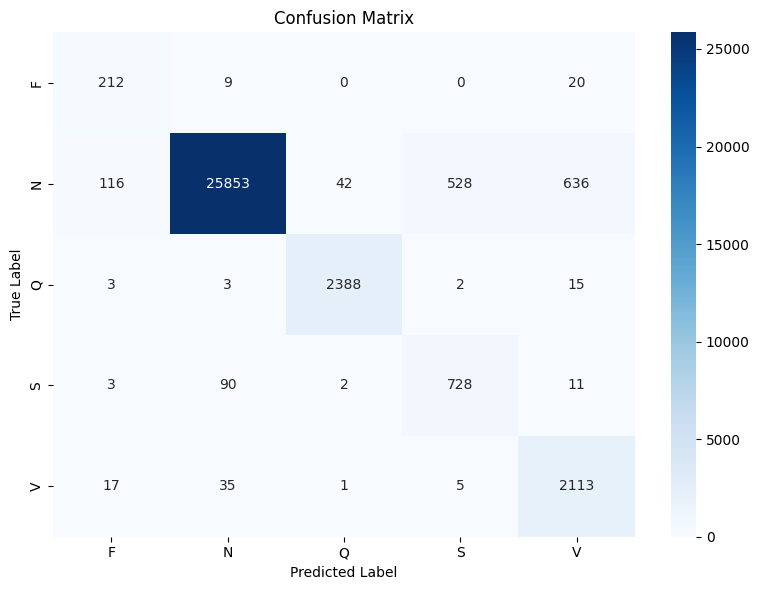

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from collections import Counter

# === Load the balanced training set ===
train_path = r'C:\Users\ENAS.DESKTOP-CSI0DAD\Desktop\ecg\me\dataset\ECG Signal Processing and Segmentation\train_balanced_8000.xlsx'
train_df = pd.read_excel(train_path)
X_train = train_df.iloc[:, :-1].values
y_train = train_df.iloc[:, -1].astype(str).values

# === Load the imbalanced test set ===
test_path = r'C:\Users\ENAS.DESKTOP-CSI0DAD\Desktop\ecg\me\dataset\ECG Signal Processing and Segmentation\test_imbalanced.xlsx'
test_df = pd.read_excel(test_path)
X_test = test_df.iloc[:, :-1].values
y_test = test_df.iloc[:, -1].astype(str).values

# === Show class distributions ===
print(f"Train class distribution: {Counter(y_train)}")
print(f"Test class distribution: {Counter(y_test)}")

# === Train the Random Forest classifier with class_weight='balanced' ===
clf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
clf.fit(X_train, y_train)

# === Predict on test data ===
y_pred = clf.predict(X_test)

# === Evaluate the model ===
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred, labels=['F', 'N', 'Q', 'S', 'V'])  # consistent label order
class_report = classification_report(y_test, y_pred, labels=['F', 'N', 'Q', 'S', 'V'])

# === Print results ===
print(f"\nAccuracy: {accuracy:.4f}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)

# === Confusion matrix visualization ===
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['F', 'N', 'Q', 'S', 'V'],
            yticklabels=['F', 'N', 'Q', 'S', 'V'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()
